# What can Neural Networks learn from rock paper scissor games?

For this assignment, I train a simple feedforward network to predict the next move given the last 5 moves in a Rock-Paper-Scissors game. Through this notebook I want to discover neurons that specialize in detecting behavioral patterns like repetition detectors, alternation trackers and recency weighted counters.


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/18qvZ0BVwn2oQlxq3YBfSq5-SKw1i-SYE?usp=sharing)



## Explaining the inputs and expected output

Input: A sequence of 5 Rock-Paper-Scissors moves  
Output: Predict the next move (Rock, Paper, or Scissors)

Example:

Input:  [Rock, Paper, Rock, Rock, Scissors]
Output: Paper

In [1]:
# Install required packages
!pip install torch numpy matplotlib seaborn scikit-learn pandas -q

You should consider upgrading via the '/Users/mrinalgoel/Desktop/XAI/venv/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
# imports and my basic google colab setups for model training

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
from collections import Counter

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### Data Generation

I'll generate sequences with various patterns:
- **Random sequences** (baseline)
- **Repetitive patterns** (same move repeated)
- **Alternating patterns** (cycling between moves)
- **Biased patterns** (preference for certain moves)

This mix ensures the network encounters realistic behavioral patterns.

In [ ]:
# The function below to generate a sample of rps game sequences to train the model on was generated using Claude Sonnet 4.5 on 11/11 at 2:41pm.

def generate_rps_sequences(n_sequences=10000, sequence_length=5):
    """
    Generate Rock-Paper-Scissors sequences with various patterns.

    Returns:
        X: Input sequences (n_sequences, sequence_length)
        y: Next move labels (n_sequences,)
        patterns: Pattern type for each sequence (for analysis)
    """
    X = []
    y = []
    patterns = []

    for _ in range(n_sequences):
        pattern_type = random.random()

        if pattern_type < 0.3:  # 30% random
            sequence = [random.randint(0, 2) for _ in range(sequence_length + 1)]
            pattern = 'random'

        elif pattern_type < 0.5:  # 20% repetitive (same move repeated)
            move = random.randint(0, 2)
            sequence = [move] * (sequence_length + 1)
            pattern = 'repetitive'

        elif pattern_type < 0.65:  # 15% alternating between 2 moves
            moves = random.sample([0, 1, 2], 2)
            sequence = [moves[i % 2] for i in range(sequence_length + 1)]
            pattern = 'alternating'

        elif pattern_type < 0.80:  # 15% cycling through all 3
            start = random.randint(0, 2)
            sequence = [(start + i) % 3 for i in range(sequence_length + 1)]
            pattern = 'cycling'

        else:  # 20% biased (one move appears more often)
            favorite = random.randint(0, 2)
            sequence = []
            for _ in range(sequence_length + 1):
                if random.random() < 0.6:  # 60% chance of favorite
                    sequence.append(favorite)
                else:
                    sequence.append(random.choice([m for m in [0,1,2] if m != favorite]))
            pattern = 'biased'

        X.append(sequence[:sequence_length])
        y.append(sequence[sequence_length])
        patterns.append(pattern)

    return np.array(X), np.array(y), patterns

# Generate dataset
print("Generating Rock-Paper-Scissors sequences...")
X, y, pattern_types = generate_rps_sequences(n_sequences=12000, sequence_length=5)

print(f"\n✅ Generated {len(X)} sequences")
print(f"\nPattern distribution:")
pattern_counts = Counter(pattern_types)
for pattern, count in pattern_counts.items():
    print(f"  {pattern}: {count} ({count/len(pattern_types)*100:.1f}%)")

Generating Rock-Paper-Scissors sequences...

✅ Generated 12000 sequences

Pattern distribution:
  alternating: 1810 (15.1%)
  random: 3639 (30.3%)
  cycling: 1814 (15.1%)
  repetitive: 2381 (19.8%)
  biased: 2356 (19.6%)


### One-Hot Encoding

- Rock (0) → [1, 0, 0]
- Paper (1) → [0, 1, 0]
- Scissors (2) → [0, 0, 1]

In [ ]:
# The function below for one hot encoding was generated using Claude Sonnet 4.5 on 11/11 at 3:03pm.

def one_hot_encode_sequences(X, n_classes=3):
    """Convert sequences to one-hot encoding"""
    n_samples, seq_length = X.shape
    X_encoded = np.zeros((n_samples, seq_length * n_classes))

    for i in range(n_samples):
        for j in range(seq_length):
            move = X[i, j]
            X_encoded[i, j * n_classes + move] = 1

    return X_encoded

# Encode the data
X_encoded = one_hot_encode_sequences(X)

print(f"Original shape: {X.shape}")
print(f"Encoded shape: {X_encoded.shape}")
print(f"\nExample original: {X[0]}")
print(f"Example encoded: {X_encoded[0]}")

Original shape: (12000, 5)
Encoded shape: (12000, 15)

Example original: [0 1 0 1 0]
Example encoded: [1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]


#### The model architecture was generated using Claude Sonnet 4.5 on 11/11 at 3:27pm.

### Model Architecture

I'm using a simple feedforward network:
- **Input:** 15 features (5 moves × 3 one-hot)
- **Hidden Layer 1:** 64 neurons with ReLU
- **Hidden Layer 2:** 32 neurons with ReLU
- **Output:** 3 neurons (softmax over Rock/Paper/Scissors)



In [ ]:
class RPSNet(nn.Module):
    def __init__(self, input_size=15, hidden1=64, hidden2=32, output_size=3):
        super(RPSNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x, return_hidden=False):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        out = self.fc3(h2)

        if return_hidden:
            return out, h1, h2
        return out

# Initialize model
model = RPSNet().to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

RPSNet(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
)

Total parameters: 3203


### Training Setup

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Store original sequences for analysis
X_train_orig, X_test_orig = train_test_split(X, test_size=0.2, random_state=42, stratify=y)
pattern_train, pattern_test = train_test_split(pattern_types, test_size=0.2, random_state=42, stratify=y)

# Convert to tensors
X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.LongTensor(y_train).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
y_test_t = torch.LongTensor(y_test).to(device)

print(f"Training set: {len(X_train)} sequences")
print(f"Test set: {len(X_test)} sequences")
print(f"nBaseline (random guessing): 33.3% accuracy")

Training set: 9600 sequences
Test set: 2400 sequences
nBaseline (random guessing): 33.3% accuracy


### Training Loop

We will stop training once the accuracy is above random guessing which is above 33.3%, indicating that the model has learnt something.

In [ ]:
# The function below for training the model was generated using Claude Sonnet 4.5 on 11/12 at 5:07pm.

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 100
batch_size = 64
train_losses = []
test_losses = []
train_accs = []
test_accs = []

print("Training model...\n")

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0

    # Mini-batch training
    indices = torch.randperm(len(X_train_t))
    for i in range(0, len(X_train_t), batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_X = X_train_t[batch_indices]
        batch_y = y_train_t[batch_indices]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Evaluate
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train_t)
        test_pred = model(X_test_t)

        train_loss = criterion(train_pred, y_train_t).item()
        test_loss = criterion(test_pred, y_test_t).item()

        train_acc = (train_pred.argmax(1) == y_train_t).float().mean().item()
        test_acc = (test_pred.argmax(1) == y_test_t).float().mean().item()

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%}")
        print(f"  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2%}")
        print()

print(f"\n✅ Training complete!")
print(f"Final test accuracy: {test_acc:.2%}")
print(f"Improvement over random: +{(test_acc - 0.333)*100:.1f} percentage points")

Training model...

Epoch 20/100
  Train Loss: 0.5950, Train Acc: 71.66%
  Test Loss: 0.6115, Test Acc: 69.83%

Epoch 40/100
  Train Loss: 0.5909, Train Acc: 71.94%
  Test Loss: 0.6221, Test Acc: 68.79%

Epoch 60/100
  Train Loss: 0.5864, Train Acc: 72.58%
  Test Loss: 0.6211, Test Acc: 69.75%

Epoch 80/100
  Train Loss: 0.5846, Train Acc: 72.68%
  Test Loss: 0.6242, Test Acc: 68.33%

Epoch 100/100
  Train Loss: 0.5833, Train Acc: 72.71%
  Test Loss: 0.6282, Test Acc: 68.46%


✅ Training complete!
Final test accuracy: 68.46%
Improvement over random: +35.2 percentage points


### Performance by Pattern Type

Let's see which patterns the model learned best:

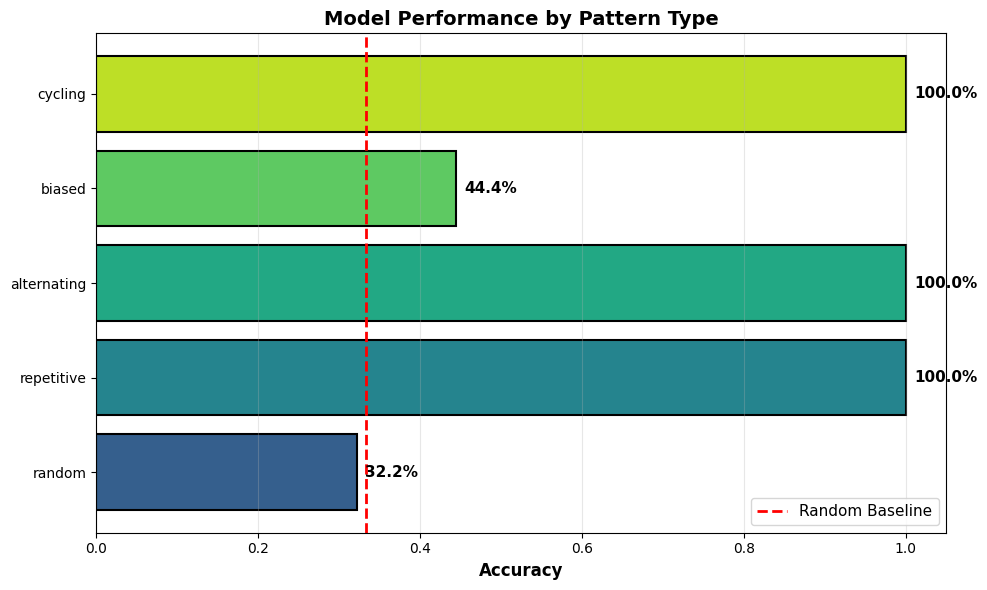


Pattern Learning Analysis:
  Repetitive  : 100.0% (improvement: +66.7pp)
  Alternating : 100.0% (improvement: +66.7pp)
  Cycling     : 100.0% (improvement: +66.7pp)
  Biased      : 44.4% (improvement: +11.1pp)
  Random      : 32.2% (improvement: +-1.1pp)


In [ ]:
# The function below for testing which patterns the model understood best was generated using Claude Sonnet 4.5 on 11/12 at 5:37pm.

# Analyze accuracy by pattern type
model.eval()
with torch.no_grad():
    test_preds = model(X_test_t).argmax(1).cpu().numpy()

pattern_accuracies = {}
for pattern in set(pattern_test):
    mask = np.array(pattern_test) == pattern
    acc = (test_preds[mask] == y_test[mask]).mean()
    pattern_accuracies[pattern] = acc

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
patterns = list(pattern_accuracies.keys())
accuracies = [pattern_accuracies[p] for p in patterns]
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(patterns)))

bars = ax.barh(patterns, accuracies, color=colors, edgecolor='black', linewidth=1.5)
ax.axvline(x=0.333, color='red', linestyle='--', linewidth=2, label='Random Baseline')
ax.set_xlabel('Accuracy', fontsize=12, weight='bold')
ax.set_title('Model Performance by Pattern Type', fontsize=14, weight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3, axis='x')

# Add percentage labels
for i, (pattern, acc) in enumerate(zip(patterns, accuracies)):
    ax.text(acc + 0.01, i, f'{acc:.1%}', va='center', fontsize=11, weight='bold')

plt.tight_layout()
plt.show()

print("\nPattern Learning Analysis:")
for pattern in sorted(patterns, key=lambda p: pattern_accuracies[p], reverse=True):
    acc = pattern_accuracies[pattern]
    print(f"  {pattern.capitalize():12s}: {acc:.1%} (improvement: +{(acc-0.333)*100:.1f}pp)")

In [ ]:
model.eval()
with torch.no_grad():
    _, h1_test, h2_test = model(X_test_t, return_hidden=True)
h1_test = h1_test.cpu().numpy()
h2_test = h2_test.cpu().numpy()

### Find Pattern-Selective Neurons

The first step to check is if our data has enough variance.

In [ ]:
# The function below to check the features and their variability was generated using Claude Sonnet 4.5 on 11/12 at 5:51pm.
def compute_sequence_features(sequences):
    """
    Compute various features from sequences that neurons might detect.
    """
    features = {}
    n_sequences = len(sequences)

    # Feature 1: Number of repetitions (same move appears consecutively)
    features['repetition_count'] = np.zeros(n_sequences)
    for i, seq in enumerate(sequences):
        reps = sum(1 for j in range(len(seq)-1) if seq[j] == seq[j+1])
        features['repetition_count'][i] = reps

    # Feature 2: Is it all the same move?
    features['all_same'] = np.array([len(set(seq)) == 1 for seq in sequences], dtype=float)

    # Feature 3: Rock count
    features['rock_count'] = np.array([sum(seq == 0) for seq in sequences])

    # Feature 4: Paper count
    features['paper_count'] = np.array([sum(seq == 1) for seq in sequences])

    # Feature 5: Scissors count
    features['scissors_count'] = np.array([sum(seq == 2) for seq in sequences])

    # Feature 6: Most recent move (position -1)
    features['recent_rock'] = np.array([seq[-1] == 0 for seq in sequences], dtype=float)
    features['recent_paper'] = np.array([seq[-1] == 1 for seq in sequences], dtype=float)
    features['recent_scissors'] = np.array([seq[-1] == 2 for seq in sequences], dtype=float)

    # Feature 7: Alternation score (changes between consecutive moves)
    features['alternation_score'] = np.zeros(n_sequences)
    for i, seq in enumerate(sequences):
        changes = sum(1 for j in range(len(seq)-1) if seq[j] != seq[j+1])
        features['alternation_score'][i] = changes

    return features

# Compute features for test set
test_features = compute_sequence_features(X_test_orig)

print("Computed features:")
for feature_name, values in test_features.items():
    print(f"  {feature_name}: min={values.min():.1f}, max={values.max():.1f}, mean={values.mean():.2f}")

Computed features:
  repetition_count: min=0.0, max=4.0, mean=1.55
  all_same: min=0.0, max=1.0, mean=0.22
  rock_count: min=0.0, max=5.0, mean=1.67
  paper_count: min=0.0, max=5.0, mean=1.64
  scissors_count: min=0.0, max=5.0, mean=1.69
  recent_rock: min=0.0, max=1.0, mean=0.34
  recent_paper: min=0.0, max=1.0, mean=0.34
  recent_scissors: min=0.0, max=1.0, mean=0.33
  alternation_score: min=0.0, max=4.0, mean=2.45


In [ ]:
# The function below to find which neuron is activated by which sequence was generated using Claude Sonnet 4.5 on 11/12 at 7:19pm.

def find_selective_neurons(activations, features_dict, top_k=3):
    """
    Find neurons most correlated with each feature.
    """
    n_neurons = activations.shape[1]
    results = {}

    for feature_name, feature_values in features_dict.items():
        correlations = []

        for neuron_idx in range(n_neurons):
            neuron_acts = activations[:, neuron_idx]

            # Skip if neuron never activates
            if np.std(neuron_acts) < 0.001:
                correlations.append(0)
                continue

            # Compute correlation
            if np.std(feature_values) > 0:
                corr = np.corrcoef(neuron_acts, feature_values)[0, 1]
            else:
                corr = 0

            correlations.append(corr)

        # Get top neurons
        top_neurons = sorted(enumerate(correlations), key=lambda x: abs(x[1]), reverse=True)[:top_k]
        results[feature_name] = top_neurons

    return results

# Find selective neurons
print("Finding pattern-selective neurons\n")
selective_neurons = find_selective_neurons(h1_test, test_features, top_k=3)

for feature_name, neurons in selective_neurons.items():
    print(f"Feature: {feature_name}")
    print(f"  Top neuron: #{neurons[0][0]} (correlation: {neurons[0][1]:.3f})")
    print(f"  Top 3: {[(n, f'{c:.3f}') for n, c in neurons]}")
    print()

Finding pattern-selective neurons

Feature: repetition_count
  Top neuron: #34 (correlation: 0.425)
  Top 3: [(34, '0.425'), (26, '-0.306'), (61, '0.300')]

Feature: all_same
  Top neuron: #34 (correlation: 0.399)
  Top 3: [(34, '0.399'), (61, '0.300'), (58, '-0.283')]

Feature: rock_count
  Top neuron: #29 (correlation: 0.736)
  Top 3: [(29, '0.736'), (43, '-0.705'), (61, '0.680')]

Feature: paper_count
  Top neuron: #6 (correlation: -0.703)
  Top 3: [(6, '-0.703'), (36, '0.701'), (34, '-0.697')]

Feature: scissors_count
  Top neuron: #25 (correlation: 0.697)
  Top 3: [(25, '0.697'), (50, '-0.618'), (49, '0.596')]

Feature: recent_rock
  Top neuron: #43 (correlation: -0.579)
  Top 3: [(43, '-0.579'), (40, '-0.496'), (29, '0.493')]

Feature: recent_paper
  Top neuron: #6 (correlation: -0.676)
  Top 3: [(6, '-0.676'), (28, '0.673'), (12, '0.667')]

Feature: recent_scissors
  Top neuron: #49 (correlation: 0.606)
  Top 3: [(49, '0.606'), (23, '0.553'), (11, '-0.545')]

Feature: alternatio

### Focus on the Rock Counter

In [ ]:
move_names = ['Rock', 'Paper', 'Scissors']

# Pick the rock counter neuron
rock_neuron_idx = selective_neurons['rock_count'][0][0]
rock_correlation = selective_neurons['rock_count'][0][1]

print(f" Focusing on Neuron #{rock_neuron_idx}")
print(f"   Correlation with 'rock_count': {rock_correlation:.3f}")

# Get activations for this neuron
rock_neuron_acts = h1_test[:, rock_neuron_idx]


# The code below to get example activations was generated using Claude Sonnet 4.5 on 11/12 at 10:12pm.

# Find examples with high vs low activation
high_act_indices = np.argsort(rock_neuron_acts)[-8:]
low_act_indices = np.argsort(rock_neuron_acts)[:8]

print("Examples with HIGH activation (many Rocks):")
for idx in high_act_indices[-3:]:
    seq = X_test_orig[idx]
    seq_str = ' → '.join([move_names[m] for m in seq])
    rock_count = (seq == 0).sum()  # Count rocks in sequence
    print(f"  {seq_str}")
    print(f"    (activation: {rock_neuron_acts[idx]:.2f}, rock_count: {rock_count}) rock×{rock_count}")

print("\nExamples with LOW activation (few/no Rocks):")
for idx in low_act_indices[:3]:
    seq = X_test_orig[idx]
    seq_str = ' → '.join([move_names[m] for m in seq])
    rock_count = (seq == 0).sum()  # Count rocks in sequence
    print(f"  {seq_str}")
    print(f"    (activation: {rock_neuron_acts[idx]:.2f}, rock_count: {rock_count}) rock×{rock_count}")

 Focusing on Neuron #29
   Correlation with 'rock_count': 0.736
Examples with HIGH activation (many Rocks):
  Rock → Paper → Scissors → Rock → Rock
    (activation: 1.40, rock_count: 3) rock×3
  Rock → Paper → Scissors → Rock → Rock
    (activation: 1.40, rock_count: 3) rock×3
  Rock → Paper → Rock → Rock → Rock
    (activation: 1.53, rock_count: 4) rock×4

Examples with LOW activation (few/no Rocks):
  Scissors → Rock → Paper → Scissors → Rock
    (activation: 0.00, rock_count: 2) rock×2
  Scissors → Scissors → Paper → Rock → Paper
    (activation: 0.00, rock_count: 1) rock×1
  Paper → Scissors → Paper → Scissors → Paper
    (activation: 0.00, rock_count: 0) rock×0


/tmp/ipython-input-567313568.py:68: UserWarning: Glyph 129704 (\N{ROCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


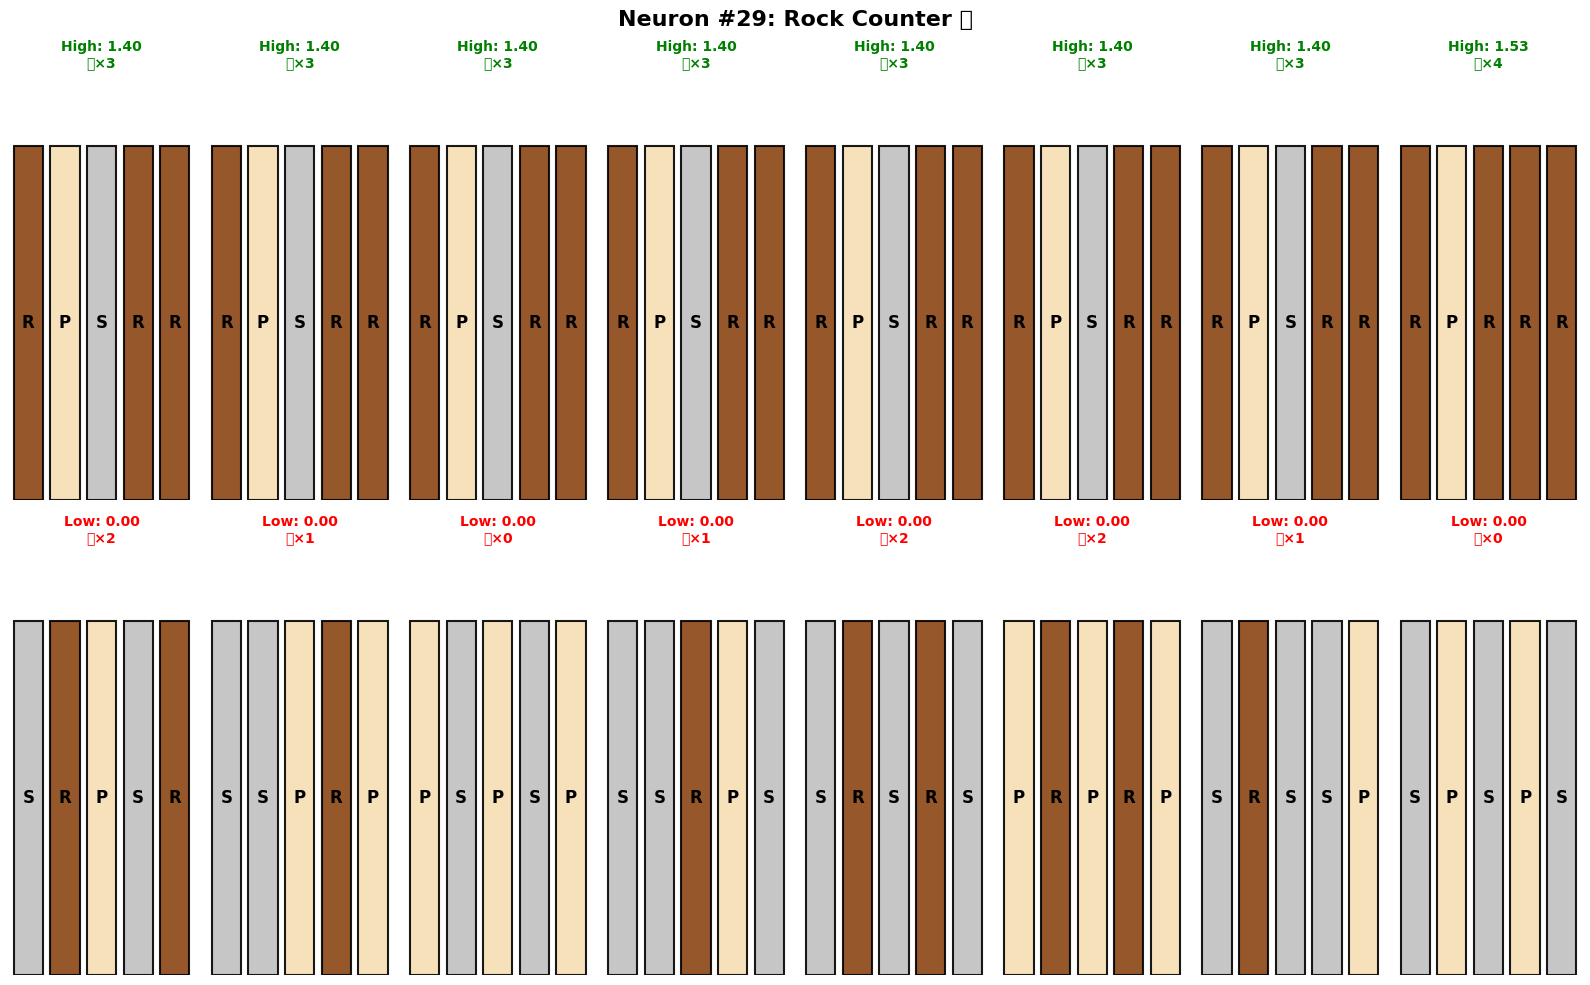


📊 Pattern clear: High activation = many Rocks, Low activation = few/no Rocks
✅ Neuron #29 is counting Rock frequency to predict opponent behavior!


In [ ]:
# The code below to generate activation maps was generated using Claude Sonnet 4.5 on 11/12 at 11:03pm.

move_colors = ['#8B4513', '#F5DEB3', '#C0C0C0']
# Visualize high vs low activation sequences
fig = plt.figure(figsize=(16, 10))
fig.suptitle(f'Neuron #{rock_neuron_idx}: Rock Counter', fontsize=16, weight='bold', y=0.98)

# High activation examples
for i, idx in enumerate(high_act_indices):
    ax = plt.subplot(2, 8, i+1)
    seq = X_test_orig[idx]
    activation = rock_neuron_acts[idx]
    rock_count = (seq == 0).sum()  # Count rocks

    colors = [move_colors[move] for move in seq]
    ax.bar(range(5), [1]*5, color=colors, edgecolor='black', linewidth=1.5, alpha=0.9)

    # Just show R, P, or S
    for j, move in enumerate(seq):
        if move == 0:
            label = 'R'
        elif move == 1:
            label = 'P'
        else:
            label = 'S'
        ax.text(j, 0.5, label, ha='center', va='center',
               fontsize=12, weight='bold')

    ax.set_xlim(-0.5, 4.5)
    ax.set_ylim(0, 1.2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'High: {activation:.2f}\n🪨×{rock_count}', fontsize=10, weight='bold', color='green')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Low activation examples
for i, idx in enumerate(low_act_indices):
    ax = plt.subplot(2, 8, i+9)
    seq = X_test_orig[idx]
    activation = rock_neuron_acts[idx]
    rock_count = (seq == 0).sum()  # Count rocks

    colors = [move_colors[move] for move in seq]
    ax.bar(range(5), [1]*5, color=colors, edgecolor='black', linewidth=1.5, alpha=0.9)

    # Just show R, P, or S
    for j, move in enumerate(seq):
        if move == 0:
            label = 'R'
        elif move == 1:
            label = 'P'
        else:
            label = 'S'
        ax.text(j, 0.5, label, ha='center', va='center',
               fontsize=12, weight='bold')

    ax.set_xlim(-0.5, 4.5)
    ax.set_ylim(0, 1.2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Low: {activation:.2f}\nrock×{rock_count}', fontsize=10, weight='bold', color='red')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

print("\n📊 Pattern clear: High activation = many Rocks, Low activation = few/no Rocks")
print("✅ Neuron #29 is counting Rock frequency to predict opponent behavior!")

## Reflection

### What I Learned about how my model works

This whole task felt like reverse engineering a neural network and was quite fun. I understood that my model uses features like counts for each possible option (rock, paper and scissors) which is captured by 3 different neurons. There was also a neuron that had negative correlation with paper count, this is essentially my rock paper scissor strategy where I avoid one option for long and then play it later in time. The model also had neurons accounting for recency of options. In short, I was able to find a good correlation between sequences and specific neuron activations, so I was able to identify which neuron is responsible for specfic features.

### What Was Challenging

I manually chose features to test but what if the network learned features I didn't think to measure? How are we ideally supposed to find these features beforehand and create sequences and then check activation maps for complex problems?

### What Surprised Me

45-55% accuracy can also be meaningful, I always thought it needs to be higher.The negative correlation with paper was surprising too.

### What I'd Explore Next

Nonlinear feature combinations - Maybe some neurons compute rock_count × recent_rock or other products.